## Import useful libraries

In [ ]:
! pip install -q kaggle

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import time
import os
import glob
from tqdm import tqdm
import random
import itertools 
from google.colab import files
from google.colab import drive

import cv2 as cv2
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the image dataset

In [ ]:
 files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
drive.mount('/content/drive')

In [ ]:
os.chdir('//content/drive/MyDrive/Colab Notebooks/Dataset/Medicines')#change dir

In [ ]:
!pwd

In [ ]:
!kaggle datasets download -d rocelleong/medicines

In [ ]:
!unzip -q medicines.zip

## Create a dataframe from the filepaths as labels

In [3]:
images_dir = r'/content/drive/MyDrive/Colab Notebooks/Dataset/Medicines'

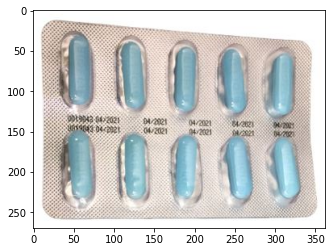

In [4]:
sample_image = images_dir + '/bioflu_counterfeit/image_696.png'
img=plt.imread(sample_image)
plt.imshow(img)

In [5]:
print('Total count of images: ', len(glob.glob(images_dir+'/*/*.png')))

Total count of images:  980


In [6]:
train_dir = glob.glob(images_dir+'/*/*.png')

train_label = []
train_image_path = []

for img in train_dir:
    train_image_path.append(img)
    basename = os.path.basename(img)
    train_label.append(img.split('/')[-2])

df = pd.DataFrame(list(zip(train_image_path, train_label)),columns =['filepaths','labels'])

In [7]:
label_encoder = preprocessing.LabelEncoder()
df['index']= label_encoder.fit_transform(df['labels'])
df

filepaths              labels  \
0    /content/drive/MyDrive/Colab Notebooks/Dataset...    bioflu_authentic   
1    /content/drive/MyDrive/Colab Notebooks/Dataset...    bioflu_authentic   
2    /content/drive/MyDrive/Colab Notebooks/Dataset...    bioflu_authentic   
3    /content/drive/MyDrive/Colab Notebooks/Dataset...    bioflu_authentic   
4    /content/drive/MyDrive/Colab Notebooks/Dataset...    bioflu_authentic   
..                                                 ...                 ...   
975  /content/drive/MyDrive/Colab Notebooks/Dataset...  neozep_counterfeit   
976  /content/drive/MyDrive/Colab Notebooks/Dataset...  neozep_counterfeit   
977  /content/drive/MyDrive/Colab Notebooks/Dataset...  neozep_counterfeit   
978  /content/drive/MyDrive/Colab Notebooks/Dataset...  neozep_counterfeit   
979  /content/drive/MyDrive/Colab Notebooks/Dataset...  neozep_counterfeit   

     index  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
975      5  
976      5  
977      5  
978      5  
979      5  

[980 rows x 3 columns]

In [8]:
df[['labels', 'index']].value_counts()

labels                index
biogesic_authentic    2        196
bioflu_authentic      0        184
biogesic_counterfeit  3        184
bioflu_counterfeit    1        152
neozep_authentic      4        132
neozep_counterfeit    5        132
dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

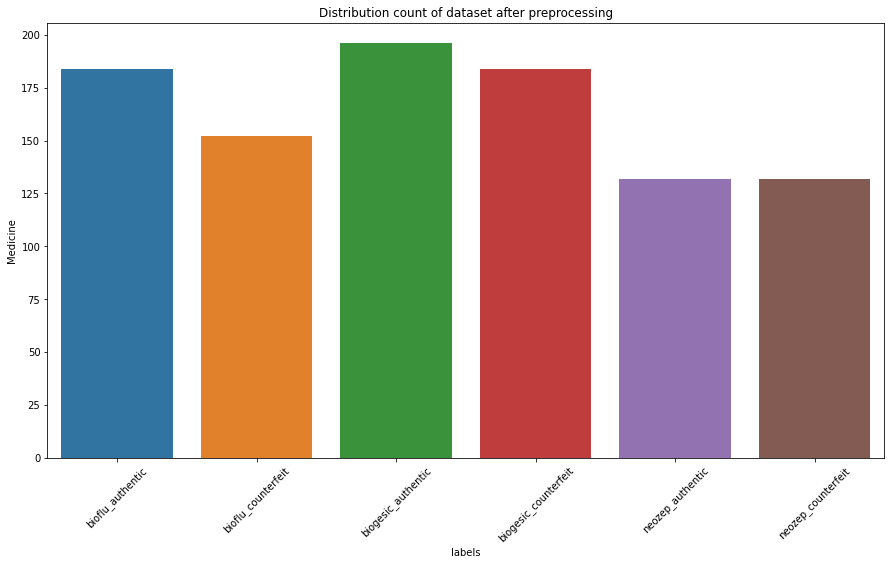

In [9]:

plt.figure(figsize=(15, 8))
sns.countplot(x=df['labels'])
plt.ylabel('Medicine')
plt.title('Distribution count of dataset after preprocessing')
plt.xticks(rotation=45)

## Display sample images

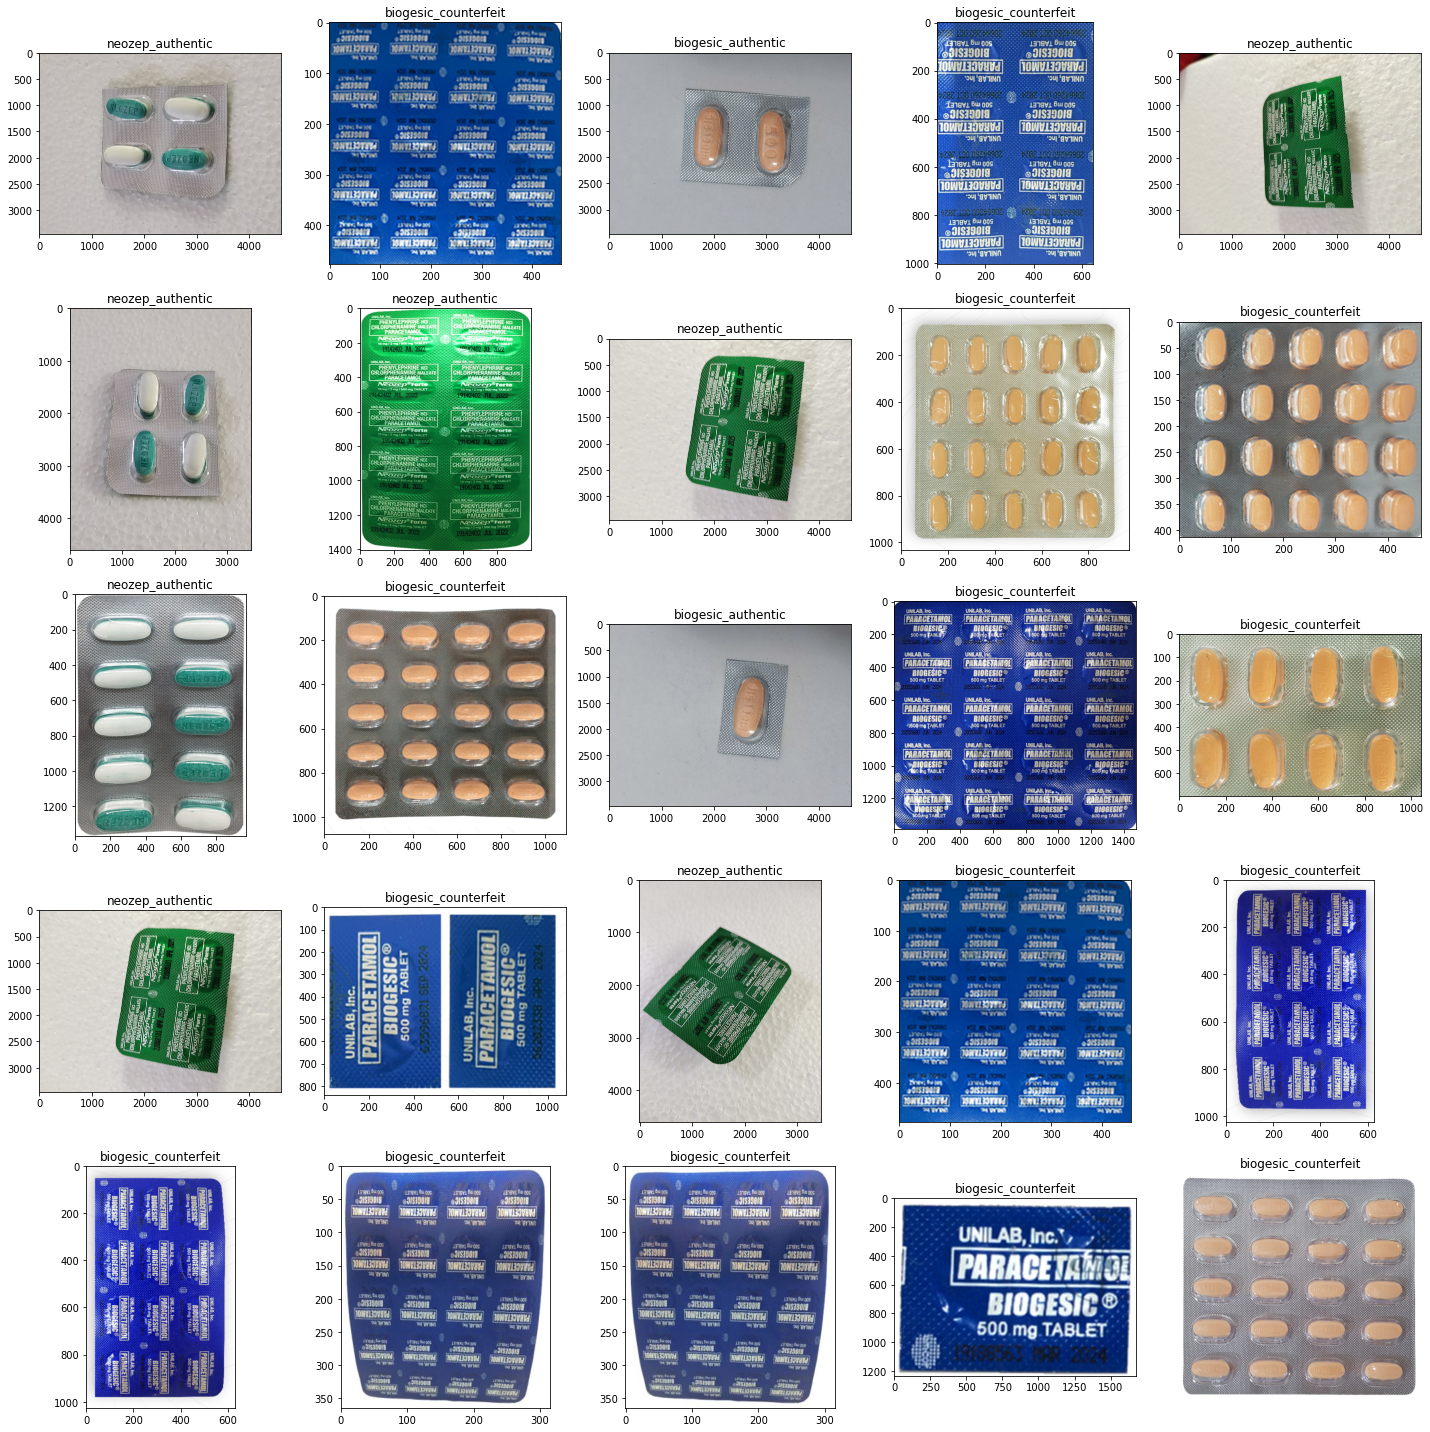

In [10]:
fig, axes = plt.subplots(nrows = 5,ncols = 5,figsize = (20, 20))

for i,ax in enumerate(axes.flat):
    y = random.randrange(500,800)
    ax.imshow(plt.imread(df["filepaths"][y]))
    ax.set_title(df["labels"][y])
plt.tight_layout()
plt.axis('off')
plt.show()

## Split the dataframe as train_df and valid_df

In [11]:
train_size = 0.75
validate_size = 0.15
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(train_size * len(df)), int((validate_size + train_size) * len(df))])

In [12]:
print('Size of train_df:',train_df.shape)
print('Size of test_df:',test_df.shape)
print('Size of valid_df:',valid_df.shape)

Size of train_df: (735, 3)
Size of test_df: (98, 3)
Size of valid_df: (147, 3)


## Create train, test and valid datagenerators

In [61]:
height,width = 224,224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)

test_batch_size = sorted([int(length/n) for n in range(1,length+1) 
                         if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps = int(length/test_batch_size)

train_datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = valid_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', 
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen = valid_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels',target_size=img_size,
    class_mode='categorical',color_mode='rgb', shuffle=True, 
    batch_size=batch_size)

classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(len(train_gen.labels)/batch_size)

Found 735 validated image filenames belonging to 6 classes.
Found 98 validated image filenames belonging to 6 classes.
Found 147 validated image filenames belonging to 6 classes.


In [50]:
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)
print(target_names)

['bioflu_authentic', 'bioflu_counterfeit', 'biogesic_authentic', 'biogesic_counterfeit', 'neozep_authentic', 'neozep_counterfeit']


## Create useful functions

### Class that will monitor the learning rate and training results of each epoch

In [15]:
"""""
  Reference: https://www.kaggle.com/gpiosenka
"""""

class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print(msg) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print(msg) 
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print(msg)  
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print(msg) 
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg) 
            self.model.stop_training = True # stop training
        if self.ask_epoch !=None:
            if epoch + 1 >= self.ask_epoch:
                msg=' enter H to halt training or an integer for how many more epochs to run before asking again'
                print(msg, '\r', end='') # prints over on the same line
                ans=input('')
                if ans=='H' or ans=='h':
                    msg=f'training has been halted at epoch {epoch + 1} due to user input'
                    print(msg) 
                    self.model.stop_training = True # stop training
                else:
                    ans=int(ans)
                    self.ask_epoch +=ans
                    

### Function that will display the classification metrics

In [16]:
def plot_training_results(model, model_name):
    df_result = pd.DataFrame(model.history.history)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(df_result[['loss']], label='Training Loss')
    plt.plot(df_result[['val_loss']], label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(df_result[['accuracy']], label='Training Accuracy')
    plt.plot(df_result[['val_accuracy']], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
def save_model(model, model_name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(f"{model_name}.tflite", 'wb') as f:
      f.write(tflite_model)

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    else:
        print('')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def classification_metrics(model, model_name, target_names):
  loss, accuracy = model.evaluate(test_gen)
  Y_pred = model.predict_generator(test_gen, length // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)
  cm =confusion_matrix(test_gen.classes, y_pred)
  plot_confusion_matrix(cm, target_names, normalize=False)
  print(f'Classification Report')
  print(classification_report(test_gen.classes, y_pred, target_names=target_names))

def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    #image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1,224,224,3)
    
    label_names = train_gen.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    score = model.predict(image).max()*100
    print('Class: {0} \nPrediction: {1}'.format(clas, name))
    print('Score: ',str(round(score,2))+'%')

# Model Development

### Model 1: EfficientNet model

In [41]:
model_name='EfficientNetB0'
eff=tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x = eff.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.001) ,activation='relu')(x)
x = Dropout(rate=.45, seed=100)(x)        
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=eff.input, outputs=output)
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

epochs = 40
patience= 1 
stop_patience =3 
threshold=.9 
factor=.5 
dwell=True 
freeze=False 
ask_epoch=15 
batches=train_steps

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, 
               threshold=threshold,factor=factor,dwell=dwell, model_name=model_name, 
               freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, 
               ask_epoch=ask_epoch)]

history=model.fit(x = train_gen, epochs=epochs, verbose=0,callbacks=callbacks,
                  validation_data = valid_gen,shuffle =False,initial_epoch=0)

 
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration
 1 /40     7.783   66.259   8.45180  63.265   0.00100  0.00100  accuracy   181.94 
 2 /40     6.270   94.966   7.18328  74.150   0.00100  0.00100  val_loss   163.07 
 3 /40     5.330   97.279   5.55588  84.354   0.00100  0.00100  val_loss   160.75 
 4 /40     4.419   98.367   4.44055  87.075   0.00100  0.00100  val_loss   160.98 
 5 /40     3.579   98.639   3.57177  89.796   0.00100  0.00100  val_loss   160.75 
 6 /40     2.860   99.320   2.80920  91.156   0.00100  0.00100  val_loss   161.95 
 7 /40     2.265   98.912   2.30037  91.837   0.00100  0.00100  val_loss   166.35 
 8 /40     1.764   99.320   1.65140  95.238   0.00100  0.00100  val_loss   162.09 
 9 /40     1.377   99.320   1.26864  97.279   0.00100  0.00100  val_loss   162.61 
10 /40     1.076   99.728   0.95102  98.639   0.00100  0.00100  val_loss   162.53 
11 /40     0.827   100.000  0.74082  97.959   0.00100  0.00100  val_loss   163.29 
12 

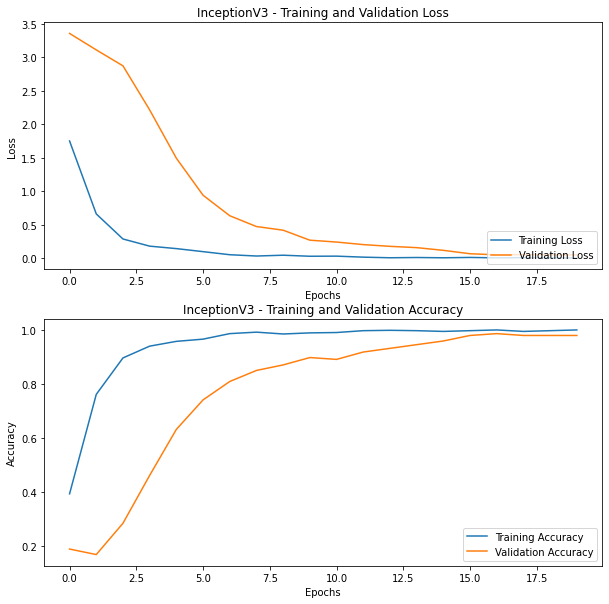

In [52]:
plot_training_results(model, model_name)

2/2 [==============================] - 15s 8s/step - loss: 0.0235 - accuracy: 0.9898


<ipython-input-16-5c8ab23004c2>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen, length // batch_size+1)



Classification Report
                      precision    recall  f1-score   support

    bioflu_authentic       1.00      1.00      1.00        13
  bioflu_counterfeit       1.00      1.00      1.00        17
  biogesic_authentic       1.00      1.00      1.00        19
biogesic_counterfeit       1.00      1.00      1.00        22
    neozep_authentic       0.93      1.00      0.96        13
  neozep_counterfeit       1.00      0.93      0.96        14

            accuracy                           0.99        98
           macro avg       0.99      0.99      0.99        98
        weighted avg       0.99      0.99      0.99        98



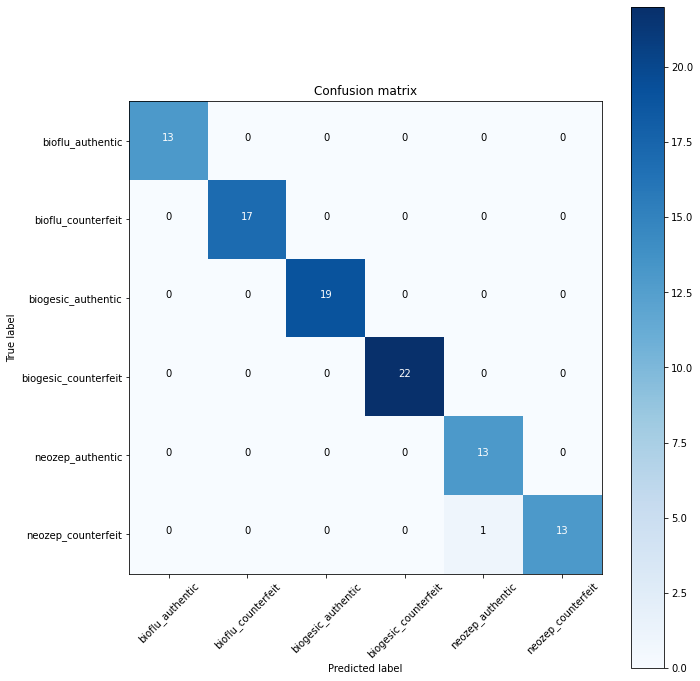

In [53]:
classification_metrics(model, model_name, target_names)

1/1 [==============================] - 0s 127ms/step
Class: 5 
Prediction: neozep_counterfeit
Score:  99.24%


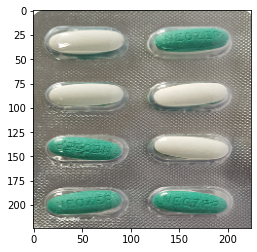

In [44]:
predictor('/content/drive/MyDrive/Colab Notebooks/Dataset/Medicines/neozep_counterfeit/image_859.png', model)

In [45]:
save_model(model, 'efficientnet')

### Model 2: InceptionV3

In [51]:
model_name='InceptionV3'
base_model=tf.keras.applications.InceptionV3(include_top=False, 
                                             weights="imagenet",input_shape=img_shape, pooling='max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.4, seed = 42)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

epochs =40
patience= 1
stop_patience =3 
threshold=.9 
factor=.5
dwell=True 
freeze=False 
ask_epoch=10
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, 
               threshold=threshold,factor=factor,dwell=dwell, model_name=model_name, 
               freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,validation_data=valid_gen,
               validation_steps=None,  shuffle=True,  initial_epoch=0)

 
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration
 1 /40     1.753   39.456   3.35834  19.048   0.00010  0.00010  accuracy   189.31 
 2 /40     0.664   76.190   3.11256  17.007   0.00010  0.00010  accuracy   169.15 
 3 /40     0.289   89.660   2.87445  28.571   0.00010  0.00010  accuracy   170.69 
 4 /40     0.183   94.014   2.21643  46.259   0.00010  0.00010  val_loss   169.61 
 5 /40     0.146   95.782   1.49531  63.265   0.00010  0.00010  val_loss   169.09 
 6 /40     0.100   96.599   0.94274  74.150   0.00010  0.00010  val_loss   169.18 
 7 /40     0.054   98.639   0.63631  80.952   0.00010  0.00010  val_loss   168.80 
 8 /40     0.035   99.184   0.47514  85.034   0.00010  0.00010  val_loss   169.43 
 9 /40     0.047   98.503   0.42064  87.075   0.00010  0.00010  val_loss   168.90 
10 /40     0.032   98.912   0.27142  89.796   0.00010  0.00010  val_loss   169.58 
10
11 /40     0.033   99.048   0.24355  89.116   0.00010  0.00010  val_loss   167.05 


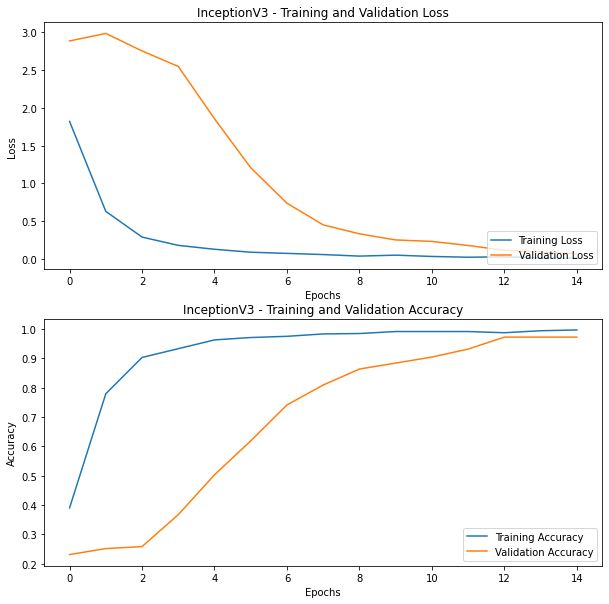

In [31]:
plot_training_results(model, model_name)

2/2 [==============================] - 15s 8s/step - loss: 0.0596 - accuracy: 0.9796


<ipython-input-16-5c8ab23004c2>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen, length // batch_size+1)



Classification Report
                      precision    recall  f1-score   support

    bioflu_authentic       1.00      1.00      1.00        13
  bioflu_counterfeit       0.89      1.00      0.94        17
  biogesic_authentic       1.00      1.00      1.00        19
biogesic_counterfeit       1.00      1.00      1.00        22
    neozep_authentic       1.00      0.92      0.96        13
  neozep_counterfeit       1.00      0.93      0.96        14

            accuracy                           0.98        98
           macro avg       0.98      0.98      0.98        98
        weighted avg       0.98      0.98      0.98        98



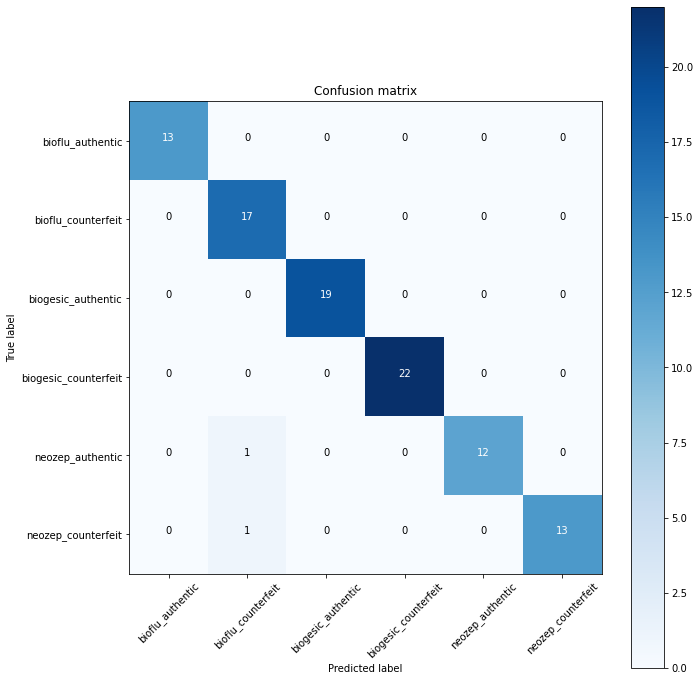

In [32]:
classification_metrics(model, model_name, target_names)

1/1 [==============================] - 0s 66ms/step
Class: 5 
Prediction: neozep_counterfeit
Score:  98.6%


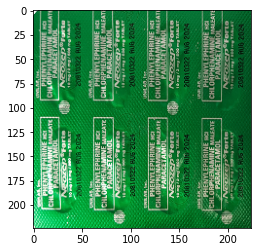

In [33]:
predictor('/content/drive/MyDrive/Colab Notebooks/Dataset/Medicines/neozep_counterfeit/image_862.png', model)

In [34]:
save_model(model, 'inception')

## Model 3: ResNet50

In [71]:
model_name='ResNet50'
base_model=tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                             weights="imagenet",input_shape=img_shape, pooling='max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.2, seed = 42)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

epochs =40
patience= 1
stop_patience =3 
threshold=.9 
factor=.5
dwell=True 
freeze=False 
ask_epoch=10
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, 
               threshold=threshold,factor=factor,dwell=dwell, model_name=model_name, 
               freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration
 1 /40     1.058   63.673   2.74186  46.939   0.00010  0.00010  accuracy   227.18 
 2 /40     0.163   94.422   1.33682  66.667   0.00010  0.00010  val_loss   201.77 
 3 /40     0.054   98.503   0.93957  70.748   0.00010  0.00010  val_loss   200.24 
 4 /40     0.030   99.048   0.81456  74.150   0.00010  0.00010  val_loss   207.29 
 5 /40     0.024   99.728   0.57106  82.313   0.00010  0.00010  val_loss   205.41 
 6 /40     0.021   99.456   0.46560  85.034   0.00010  0.00010  val_loss   201.76 
 7 /40     0.010   99.864   0.40418  89.116   0.00010  0.00010  val_loss   201.28 
 8 /40     0.012   99.728   0.29371  89.796   0.00010  0.00010  val_loss   201.36 
 9 /40     0.005   100.000  0.24077  89.796   0.00010  0.00010  val_loss   200.94 
10 /40     0.006   99.728   0.14786  93.197   0.00010  0.00010  val_loss   194.74 
10
11 /40     0.004   100.000  0.17396  93.197   0.00010  0.00005  val_loss   194.00 


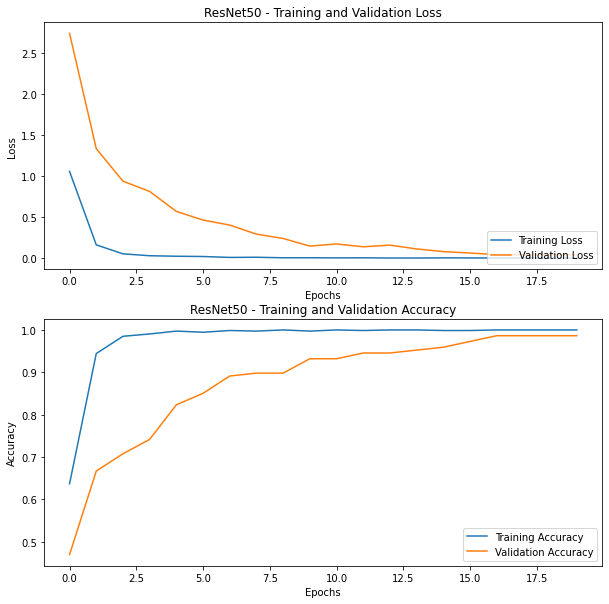

In [72]:
plot_training_results(model, model_name)

2/2 [==============================] - 20s 12s/step - loss: 0.0272 - accuracy: 0.9898


<ipython-input-17-5c8ab23004c2>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen, length // batch_size+1)



Classification Report
                      precision    recall  f1-score   support

    bioflu_authentic       1.00      1.00      1.00        13
  bioflu_counterfeit       1.00      1.00      1.00        16
  biogesic_authentic       1.00      1.00      1.00        18
biogesic_counterfeit       1.00      1.00      1.00        23
    neozep_authentic       0.95      1.00      0.98        20
  neozep_counterfeit       1.00      0.88      0.93         8

            accuracy                           0.99        98
           macro avg       0.99      0.98      0.98        98
        weighted avg       0.99      0.99      0.99        98



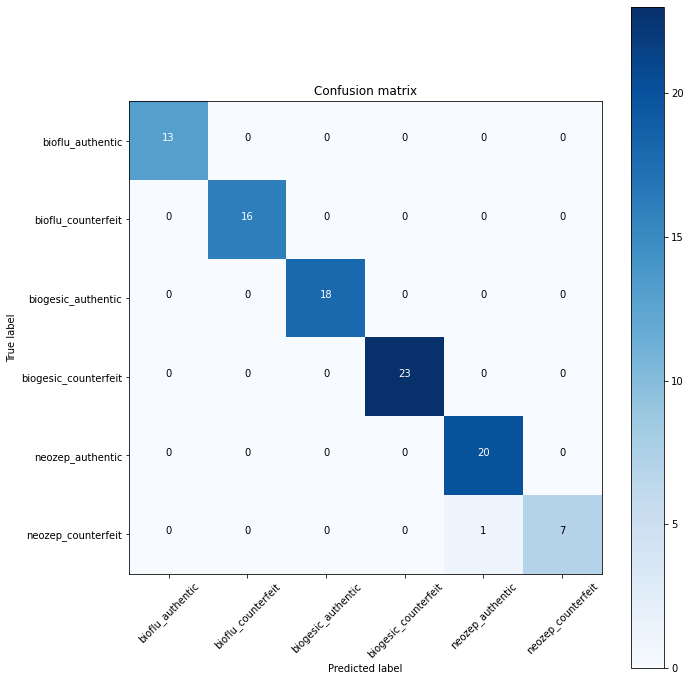

In [73]:
classification_metrics(model, model_name, target_names)

1/1 [==============================] - 0s 80ms/step
Class: 5 
Prediction: neozep_counterfeit
Score:  97.7%


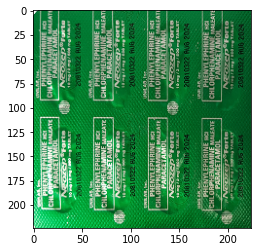

In [21]:
predictor('/content/drive/MyDrive/Colab Notebooks/Dataset/Medicines/neozep_counterfeit/image_862.png', model)

In [74]:
save_model(model, 'resnet50')